In [1]:
# coding: utf-8

# In[2]:

get_ipython().system(u'pip install nilearn')


# In[1]:

import numpy as np
from scipy import linalg

from nilearn import datasets
from nilearn.input_data import NiftiMasker

from nilearn.image import smooth_img
import numpy as np
import cv2

import keras
import tensorflow.compat.v1 as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 4.0 MB/s 


/usr/local/lib/python3.8/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [ ]:
tf.disable_v2_behavior()

n_subjects = 416

oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
gm_imgs = gray_matter_map_filenames

In [3]:
cdr = oasis_dataset.ext_vars['cdr'].astype(float)
cdr_numpy_arr = np.array(cdr)
for i in range(len(cdr_numpy_arr)):
    if(np.isnan(cdr_numpy_arr[i])): cdr_numpy_arr[i] = 1
    
    elif(cdr_numpy_arr[i] > 0.0): cdr_numpy_arr[i] = 1

In [4]:
imgArr = []

for imgUrl in gray_matter_map_filenames:
    result_img = smooth_img(imgUrl, fwhm=1)
    imgArr.append(result_img.get_data())

<ipython-input-4-a233924848ec>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  imgArr.append(result_img.get_data())


In [5]:
x_train = []
x_test = []

y_train = []
y_test = []

rshapedImgArr = []

for img in imgArr:
    newImg = [cv2.resize(each_slice,(50,50)) for each_slice in img]#Reducing slice count
    newImg = np.array(newImg)
    rshapedImgArr.append(newImg)
    
label = cdr_numpy_arr

In [6]:
label = keras.utils.to_categorical(cdr_numpy_arr, 2)

much_data = []

for num, img in enumerate(rshapedImgArr):
    much_data.append([img,label[num]])

In [7]:
import tensorflow.compat.v1 as tf
import numpy as np

IMG_SIZE_PX_X = 50
IMG_SIZE_PX_Y = 50
SLICE_COUNT = 91

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [8]:
def conv3d(x, W):
    conv = tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')
    conv = tf.nn.dropout(conv, 0.5)
    return conv

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')



In [9]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([248768,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX_X, IMG_SIZE_PX_Y, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 248768])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [10]:
# train_data = much_data[:-333]
# validation_data = much_data[-83:]

from sklearn.model_selection import train_test_split

def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    #file = open("output.txt", "w");
    file = open("output.txt", "w");
    
    hm_epochs = 25
    #hm_epochs = 2
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            
            train_data, validation_data = train_test_split(much_data, train_size=0.8)
            
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
            #f.write("{} {} {}\n".format(a, b, c))
            file.write('Epoch{}completed out of{}loss:{}\n'.format(epoch+1, hm_epochs, epoch_loss));
            #file.writelines('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss);
            #file.write('Epoch')
            #file.write(str(epoch+1))
            #file.write('completed out of',hm_epochs)
            #file.write('completed out of ')
            #file.write(str(hm_epochs))
            #file.write('loss: ')
            #file.write('loss:',epoch_loss);
            #file.write(str(epoch_loss))

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            #file.writelines('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            file.write('Accuracy:{}\n'.format(accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]})))
            #file.write('Accuracy: ')
            #file.write(str(accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]})))
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)
        
        file.write('Done. Finishing accuracy:')
        #file.writelines('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        file.write('Accuracy:{}\n'.format(accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]})))
        #file.write('Accuracy: ')
        #file.write(str(accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]})))
        
        #file.write('fitment percent: ')
        #file.write(str(successful_runs/total_runs))
        #file.writelines('fitment percent:',successful_runs/total_runs)
        file.write('fitment percent{}'.format(successful_runs/total_runs))

train_neural_network(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch 1 completed out of 25 loss: 307297691.34375
Accuracy: 0.79012346
Epoch 2 completed out of 25 loss: 82022028.5703125
Accuracy: 0.654321
Epoch 3 completed out of 25 loss: 36057431.34375
Accuracy: 0.67901236
Epoch 4 completed out of 25 loss: 16053137.67578125
Accuracy: 0.5802469
Epoch 5 completed out of 25 loss: 11933029.373046875
Accuracy: 0.6666667
Epoch 6 completed out of 25 loss: 8874264.66796875
Accuracy: 0.6296296
Epoch 7 completed out of 25 loss: 7979462.517578125
Accuracy: 0.7407407
Epoch 8 completed out of 25 loss: 5792025.097290039
Accuracy: 0.654321
Epoch 9 completed out of 25 loss: 4797067.879394531
Accuracy: 0.56790125
Epoch 10 completed out of 25 loss: 4000727.842529297
Accuracy: 0.6419753
Epoch 11 completed out of 25 loss: 3249982.8828125
Accuracy: 0.5925926
Epoch 12 completed out of 25 loss: 3066452.123046875
Accuracy: 0.67901236
Epoch 13 completed out of 25 loss: 2155280.3774294853
Accuracy: 0.6296296
Epoch 14 completed out of 25 loss: 1741184.709678607
Accuracy: 0.

<ipython-input-13-fceecf943260>:3: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  img = load_mni152_template()


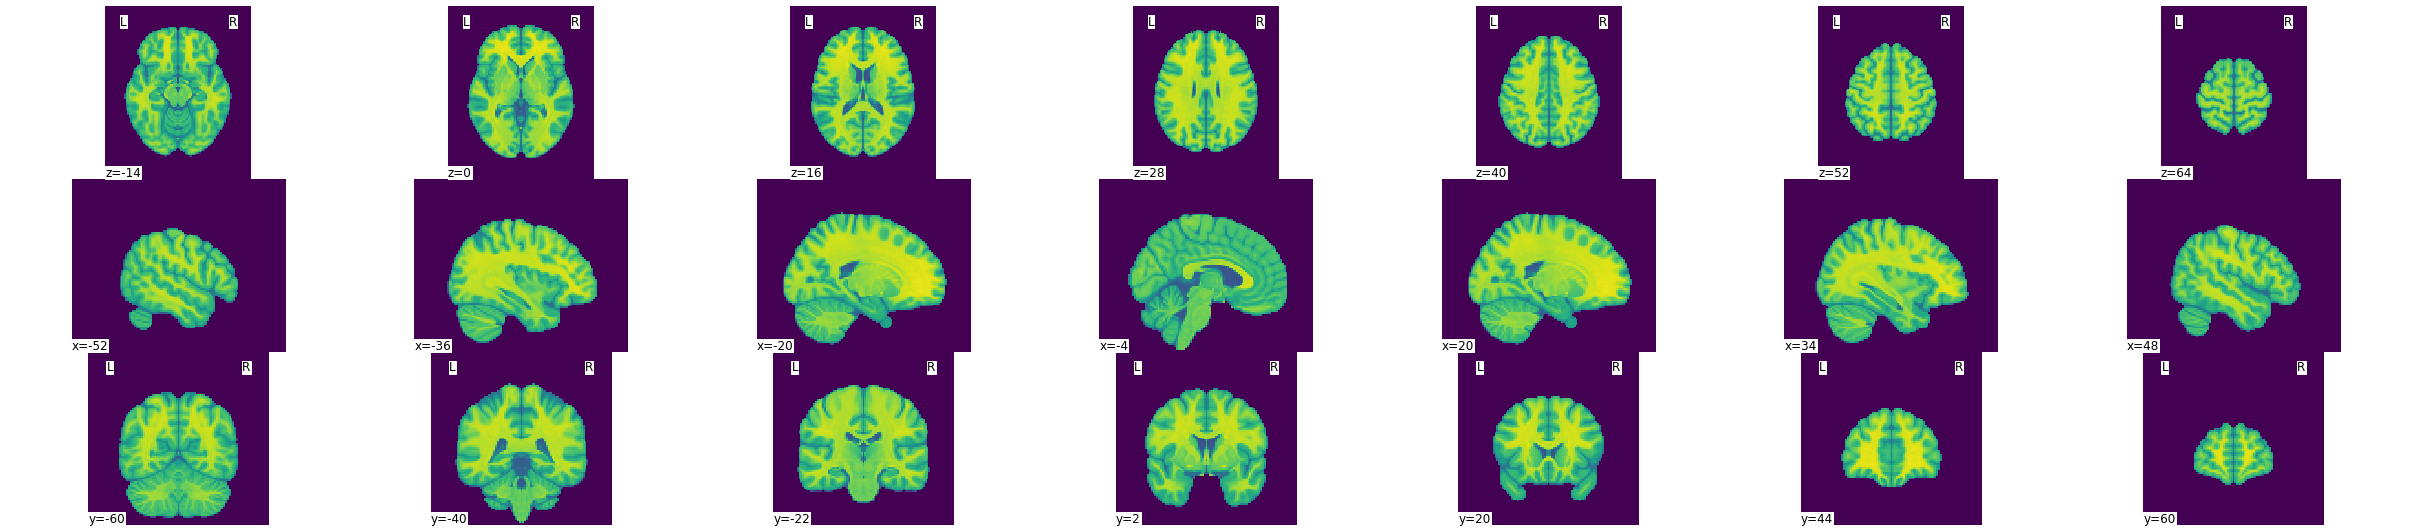

In [13]:
from nilearn.datasets import load_mni152_template
from nilearn.plotting import plot_img
img = load_mni152_template()
# display is an instance of the TiledSlicer class

display1 = plot_img(img, display_mode='mosaic')